## 安装


### 导入和配置模块

In [27]:
import os
import tensorflow as tf
# Load compressed mode|ls from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [28]:
tf.__version__

'2.5.0'

In [29]:
from tensorflow.python.client import device_lib
# 列出所有的本地机器设备
local_device_protos = device_lib.list_local_devices()

In [30]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [31]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

下载图像并选择风格图像和内容图像：

In [32]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
# style_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
# style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')
content_path='dataset/c1.jpg'
style_path ='dataset/s1.jpg'

## 呈现输入

定义一个加载图像的函数

In [33]:
def load_img(path_to_img):
  max_dim = 1024
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

创建一个简单的函数来显示图像：

In [34]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)
  plt.tick_params(labelsize=10)
  plt.imshow(image)
  if title:
    plt.title(title,fontsize = 20)

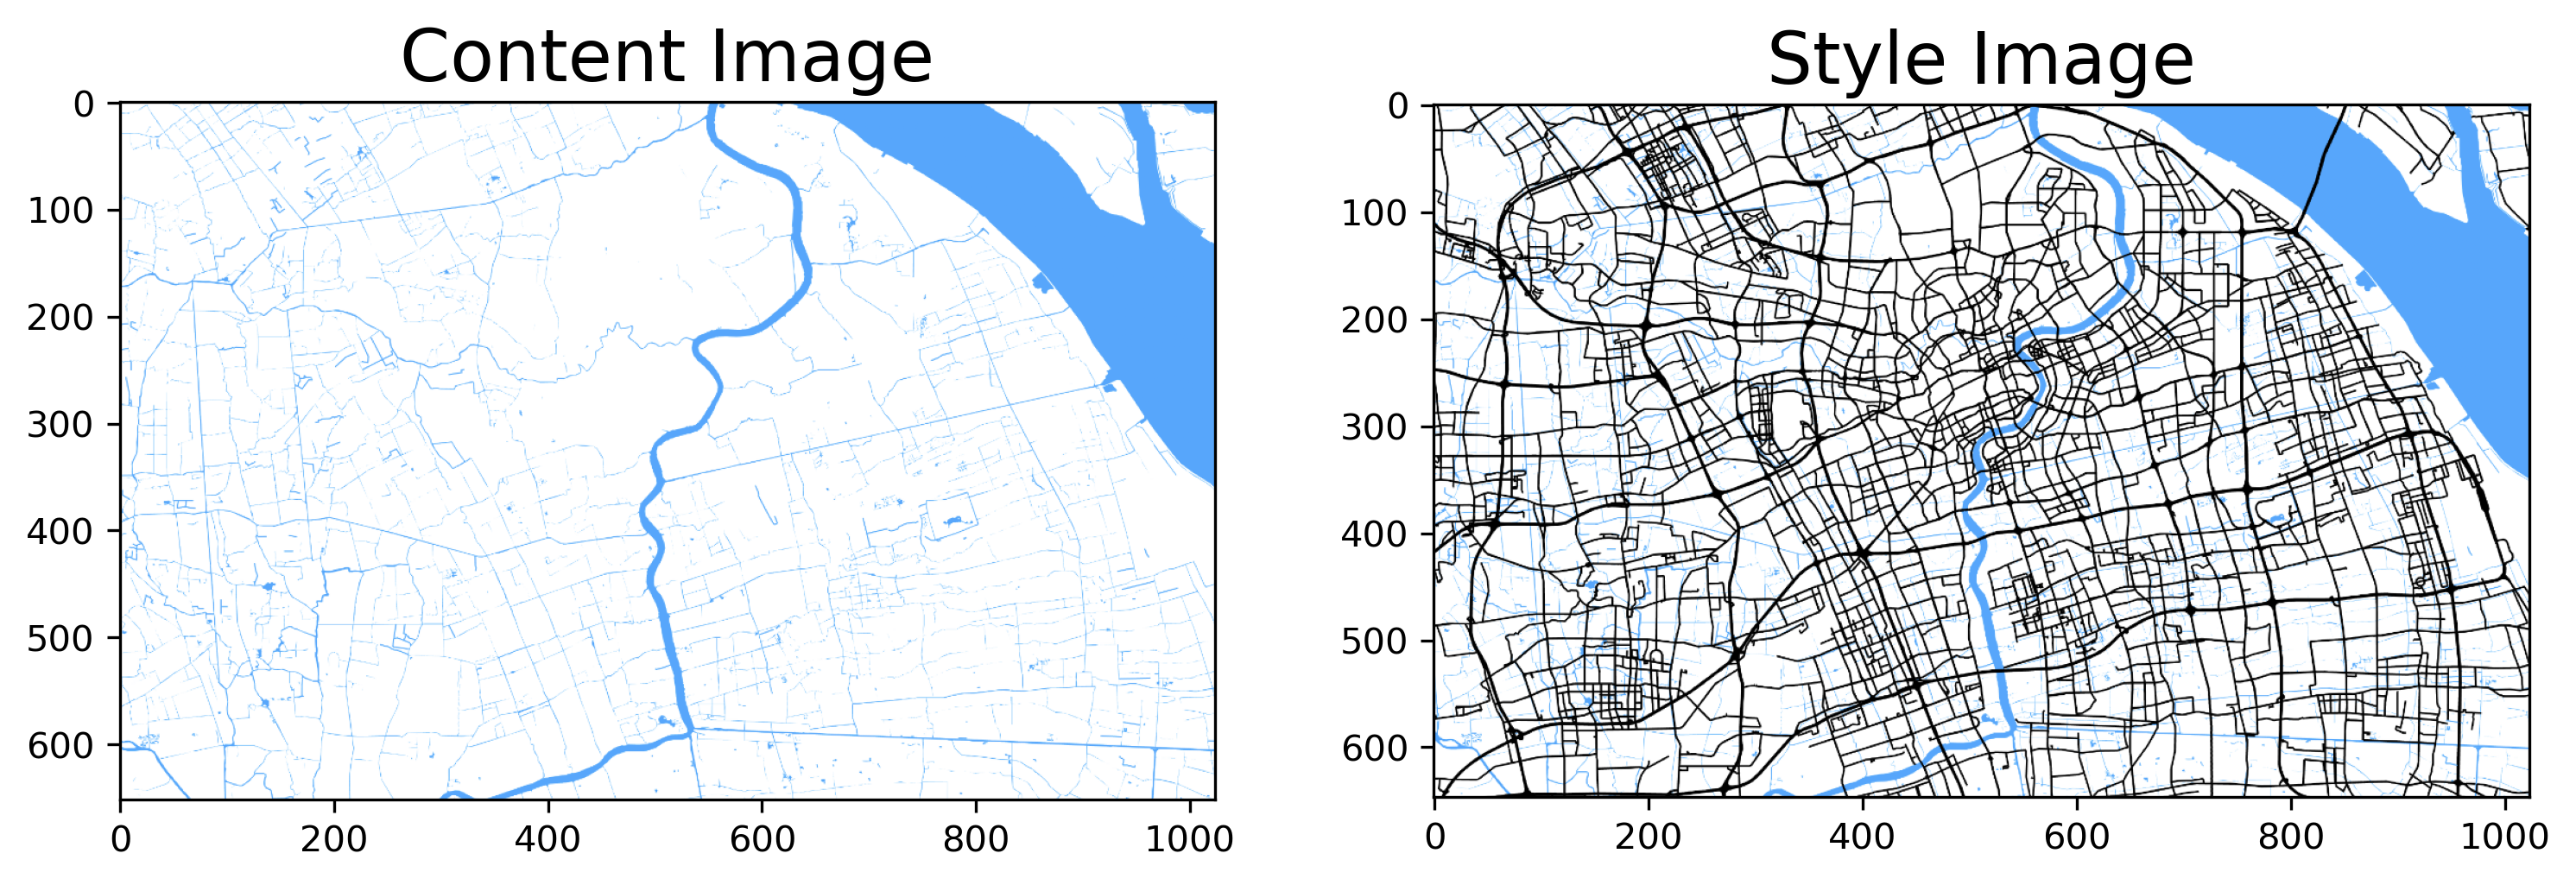

In [35]:
content_image = load_img(content_path)
style_image = load_img(style_path)
plt.figure(dpi=300)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## 定义内容和风格的表示

使用模型的中间层来获取图像的*内容*和*风格*表示。从网络的输入层开始，前几个层的激活表示边缘和纹理等低级特征。随着深入网络，最后几层代表更高级的特征 – 对象部分，如*轮子*或*眼睛*。我们使用的是 VGG19 网络架构，这是一个已经预训练好的图像分类网络。这些中间层是从图像中定义内容和风格的表示所必需的。对于输入图像，我们尝试匹配这些中间层的相应风格和内容目标的表示。


现在，加载没有分类部分的 `VGG19` ，并列出各层的名称：

In [36]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet',pooling='avg')

for layer in vgg.layers:
  print(layer.name)

input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
global_average_pooling2d_2


从网络中选择中间层的输出以表示图像的风格和内容：


In [37]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#### 用于表示风格和内容的中间层

那么,为什么我们预训练的图像分类网络中的这些中间层的输出允许我们定义风格和内容的表示？

从高层理解，为了使网络能够实现图像分类（该网络已被训练过），它必须理解图像。 这需要将原始图像作为输入像素并构建内部表示，这个内部表示将原始图像像素转换为对图像中存在的 feature (特征)的复杂理解。

这也是卷积神经网络能够很好地泛化的原因：它们能够捕获不变性并定义类内的特征（例如猫与狗），这些特征与背景噪声和其他滋扰无关。因此，在将原始图像输入模型和输出分类标签之间的某个位置，该模型用作复杂的特征提取程序。通过访问模型的中间层，您可以描述输入图像的内容和风格。

## 构建模型

`tf.keras.applications` 中的网络让您可以使用 Keras 函数式 API 轻松提取中间层值。

要使用函数式 API 定义模型，请指定输入和输出：

`model = Model(inputs, outputs)`

以下函数构建了一个 VGG19 模型，该模型返回一个中间层输出的列表：

In [38]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

## 风格计算

图像的内容由中间 feature maps (特征图)的值表示。

事实证明，图像的风格可以通过不同 feature maps (特征图)上的平均值和相关性来描述。 通过在每个位置计算 feature (特征)向量的外积，并在所有位置对该外积进行平均,可以计算出包含此信息的 Gram 矩阵。 对于特定层的 Gram 矩阵，具体计算方法如下所示：

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

这可以使用 `tf.linalg.einsum` 函数简洁地实现：

In [39]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## 提取风格和内容


构建一个返回风格和内容张量的模型。

In [40]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

在图像上调用此模型，可以返回 `style_layers` 的 gram 矩阵（风格）和 `content_layers` 的内容：

## 运行梯度下降

使用此风格和内容提取程序，我们现在可以实现风格传输算法。我们通过计算每个图像的输出和目标的均方误差来做到这一点，然后取这些损失值的加权和。

设置风格和内容的目标值：

In [41]:
extractor = StyleContentModel(style_layers, content_layers)
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

定义一个 `tf.Variable` 来表示要优化的图像。 为了快速实现这一点，使用内容图像对其进行初始化（ `tf.Variable` 必须与内容图像的形状相同）

由于这是一个浮点图像，因此我们定义一个函数来保持像素值在 0 和 1 之间：

In [42]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

为了优化它，我们使用两个损失的加权组合来获得总损失：

In [43]:
style_weight=1e-4
content_weight=1e4

In [44]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

使用 `tf.GradientTape` 来更新图像。

## 总变分损失

它会产生大量的高频误差。 我们可以直接通过正则化图像的高频分量来减少这些高频误差。 在风格转移中，这通常被称为*总变分损失*

## 进行优化

选择 `total_variation_loss` 的权重：

In [45]:
total_variation_weight=30

现在，将它加入 `train_step` 函数中：

In [46]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

重新初始化图像变量和优化器：

In [47]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-7)
image = tf.Variable(content_image)
img=[]

并进行优化：

In [48]:
import time
start = time.time()

epochs = 100
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
    # if step==10000:
    #     img.append(tensor_to_image(image))
    # elif step==20000:
    #     img.append(tensor_to_image(image))
    # elif step==30000:
    #     img.append(tensor_to_image(image))
    # elif step==40000:
    #     img.append(tensor_to_image(image))
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

...........................

KeyboardInterrupt: 

In [ ]:
# plt.figure(dpi=500,figsize=(15,10))
# plt.subplot(2, 2, 1)
# # imshow(style_image, 'Original Texture')
# plt.title('10000 Iterations',fontsize = 20)
# plt.subplot(2, 2, 2)
# plt.imshow(img[0])
# plt.title('20000 Iterations',fontsize = 20)
# plt.subplot(2, 2, 3)
# plt.imshow(img[1])
# plt.title('30000 Iterations',fontsize = 20)
# plt.subplot(2, 2, 4)
# plt.imshow(img[2])
# plt.title('40000 Iterations',fontsize = 20)

In [ ]:
# plt.figure(dpi=500,figsize=(15,10))
# plt.subplot(2, 2, 1)
# imshow(style_image, 'Original Image')
# plt.subplot(2, 2, 2)
# imshow(img[0], '1000 iterations')
# plt.subplot(2, 2, 3)
# imshow(img[1], '5000 iterations')
# plt.subplot(2, 2, 4)
# imshow(img[2], '10000 iterations')

最后，保存结果：

In [ ]:
# file_name = 'stylized-image.png'
# tensor_to_image(image).save(file_name)

# try:
#   from google.colab import files
# except ImportError:
#    pass
# else:
#   files.download(file_name)

In [ ]:
import os
print(os.path.abspath('.'))